In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize' : (16,9)})

In [3]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', \
                          compression ='zip')

In [4]:
events_data.head()

step_id   timestamp      action  user_id
0    32815  1434340848      viewed    17632
1    32815  1434340848      passed    17632
2    32815  1434340848  discovered    17632
3    32811  1434340895  discovered    17632
4    32811  1434340895      viewed    17632

In [5]:
events_data['date'] = pd.to_datetime(events_data['timestamp'], unit='s')
events_data['day'] = events_data['date'].dt.date
events_data.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

In [6]:
events_data.shape[0]

3480703

[(0.0, 50000.0)]

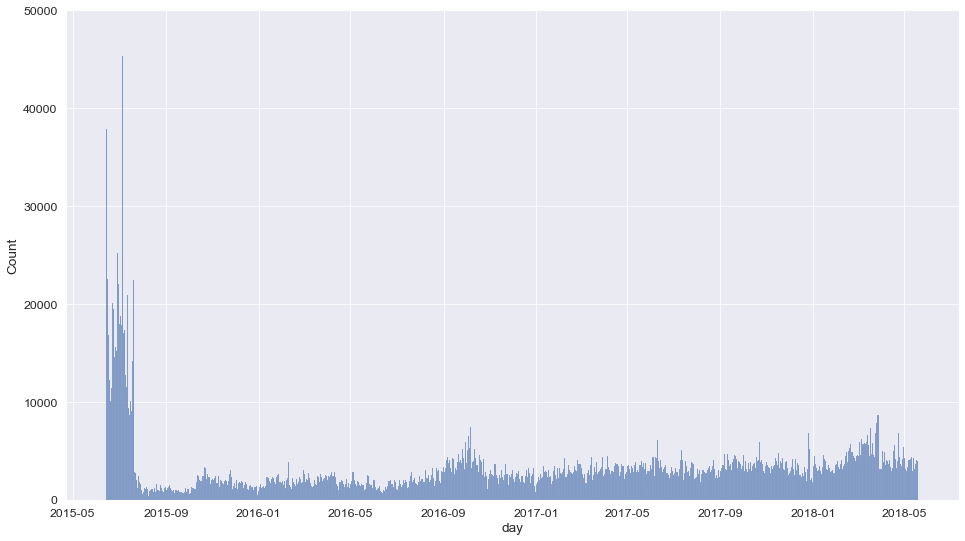

In [7]:
sns.set_context('paper', font_scale=1.4)
ax = sns.histplot(events_data['day'], \
                  bins=40)
ax.set(ylim=(0, 50000))

<AxesSubplot:xlabel='day'>

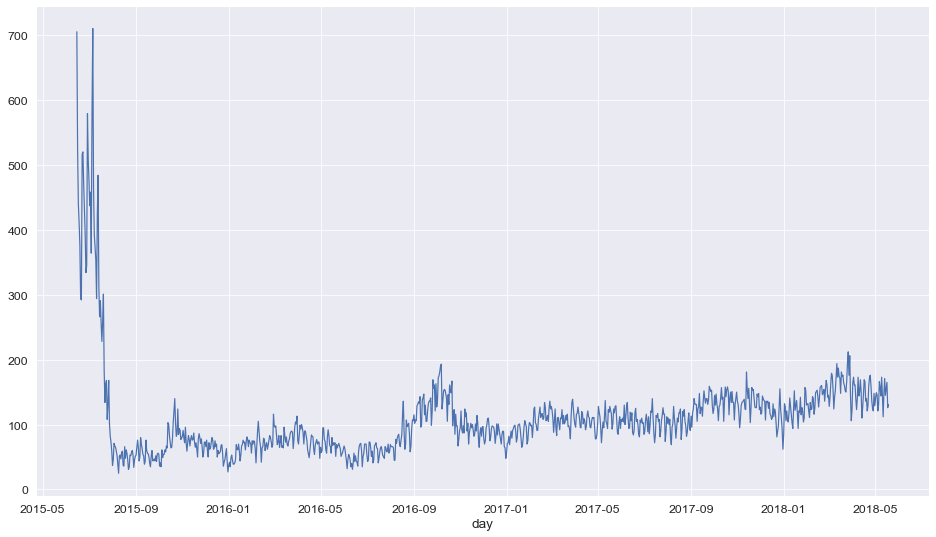

In [8]:
events_data.groupby('day')['user_id'].nunique().plot()

In [9]:
events_data['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [10]:
# events_data.query("action == 'passed'") \
#     .groupby('user_id', as_index=False) \
#     .agg({'step_id': 'count'}) \
#     .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

<AxesSubplot:>

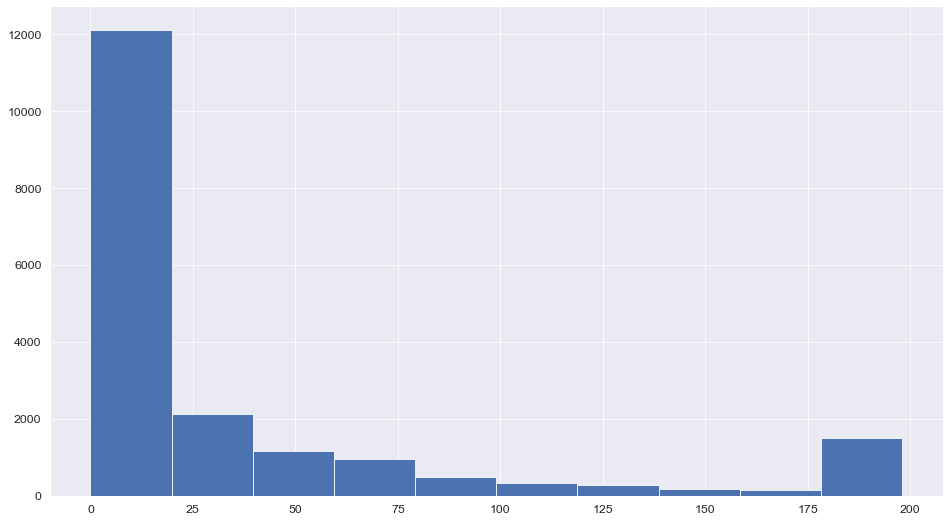

In [11]:
users_events_data = events_data.pivot_table(index='user_id', columns='action' \
                        , values='step_id', aggfunc='count', fill_value=0).reset_index() 
users_events_data.discovered.hist()

In [12]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip',compression ='zip')

In [13]:
submissions_data.shape

(509104, 4)

In [14]:
submissions_data.head()

step_id   timestamp submission_status  user_id
0    31971  1434349275           correct    15853
1    31972  1434348300           correct    15853
2    31972  1478852149             wrong    15853
3    31972  1478852164           correct    15853
4    31976  1434348123             wrong    15853

In [15]:
submissions_data['date'] = pd.to_datetime(submissions_data['timestamp'], unit='s')
submissions_data['day'] = submissions_data['date'].dt.date

In [16]:
submissions_data.head()

step_id   timestamp submission_status  user_id                date  \
0    31971  1434349275           correct    15853 2015-06-15 06:21:15   
1    31972  1434348300           correct    15853 2015-06-15 06:05:00   
2    31972  1478852149             wrong    15853 2016-11-11 08:15:49   
3    31972  1478852164           correct    15853 2016-11-11 08:16:04   
4    31976  1434348123             wrong    15853 2015-06-15 06:02:03   

          day  
0  2015-06-15  
1  2015-06-15  
2  2016-11-11  
3  2016-11-11  
4  2015-06-15

In [17]:
users_scores = pd.pivot_table(data=submissions_data, \
                              values='step_id', index='user_id', \
                              columns='submission_status', aggfunc='count', \
                              fill_value=0).reset_index()

In [18]:
users_scores.shape[0]

9940

In [19]:
users_scores.head()

submission_status  user_id  correct  wrong
0                        2        2      0
1                        3       29     23
2                        5        2      2
3                        8        9     21
4                       14        0      1

[(0.0, 95.0)]

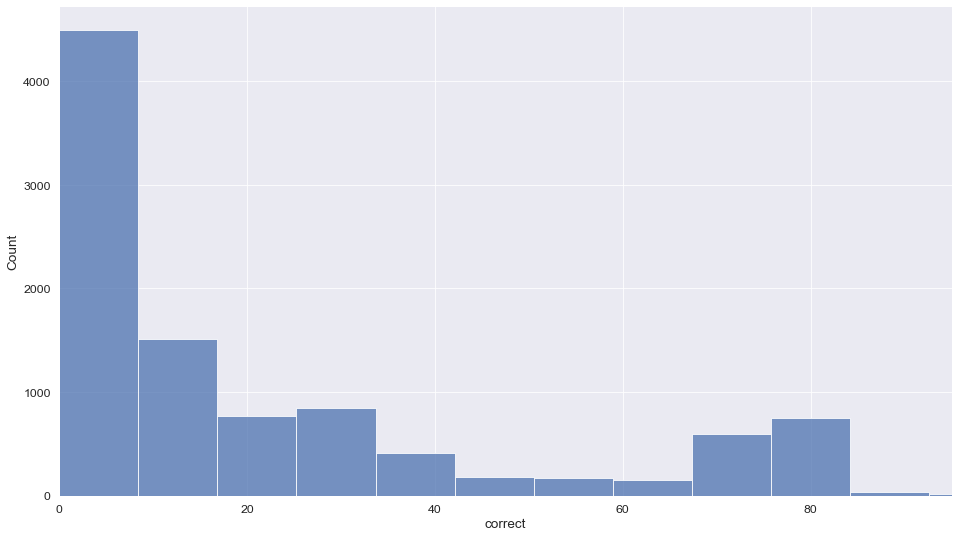

In [20]:
ax = sns.histplot(users_scores['correct'], bins=50)
ax.set(xlim=(0, 95))

In [21]:
# counting diffs between closest days
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [22]:
gap_data = pd.Series(np.concatenate(gap_data))

In [23]:
gap_data /= 24 * 60 * 60

<AxesSubplot:>

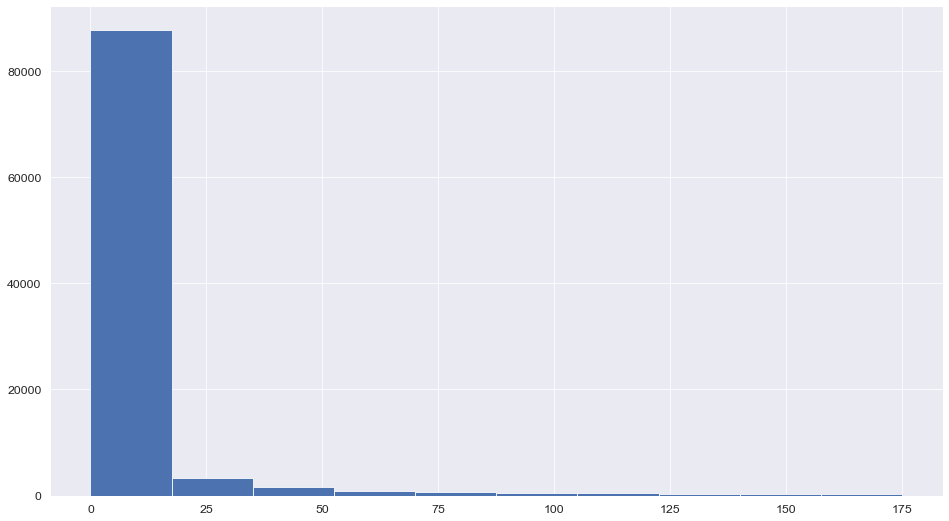

In [24]:
gap_data[gap_data < 175].hist()

In [25]:
gap_data.quantile(0.95)

59.760440972222156

In [26]:
gap_data.quantile(0.90)

18.325995370370403

### Suppose the user has dropped out if gap > 30

In [27]:
drop_out_border = 30 * 24 * 60 * 60

In [28]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})
users_data['is_gone_user'] = (events_data['timestamp'].max() \
                              - users_data['last_timestamp']) > drop_out_border
users_data

user_id  last_timestamp  is_gone_user
0            1      1472827464          True
1            2      1519226966          True
2            3      1444581588          True
3            5      1499859939          True
4            7      1521634660          True
...        ...             ...           ...
19229    26790      1517495987          True
19230    26793      1510225034          True
19231    26794      1512035039          True
19232    26797      1509995096          True
19233    26798      1520978742          True

[19234 rows x 3 columns]

In [29]:
users_data_merged = users_data.merge(right=users_scores, on='user_id', 
                 how='outer').fillna(0)
users_data_merged.shape[0]

19234

In [30]:
users_data_merged.head()

user_id  last_timestamp  is_gone_user  correct  wrong
0        1      1472827464          True      0.0    0.0
1        2      1519226966          True      2.0    0.0
2        3      1444581588          True     29.0   23.0
3        5      1499859939          True      2.0    2.0
4        7      1521634660          True      0.0    0.0

In [31]:
tmp = users_data_merged.merge(users_events_data, on='user_id', how='outer').fillna(0)
tmp.head()

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed  \
0        1      1472827464          True      0.0    0.0           1       0   
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   

   started_attempt  viewed  
0                0       1  
1                2      10  
2               30     192  
3                4      12  
4                0       1

In [32]:
events_data.columns

Index(['step_id', 'timestamp', 'action', 'user_id', 'date', 'day'], dtype='object')

In [33]:
users_days = events_data.groupby('user_id', as_index=False) \
    .day.nunique()

In [34]:
users_days.head()

user_id  day
0        1    1
1        2    2
2        3    7
3        5    2
4        7    1

In [35]:
total_user_data = tmp.merge(users_days, on='user_id', how='outer')

In [36]:
total_user_data.shape[0]

19234

In [37]:
total_user_data.head()

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed  \
0        1      1472827464          True      0.0    0.0           1       0   
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   

   started_attempt  viewed  day  
0                0       1    1  
1                2      10    2  
2               30     192    7  
3                4      12    2  
4                0       1    1

In [38]:
total_user_data['passed_course'] = total_user_data['passed'] > 170

In [39]:
total_user_data[total_user_data['passed_course']]['user_id'].count()

1425

[(0.0, 150.0)]

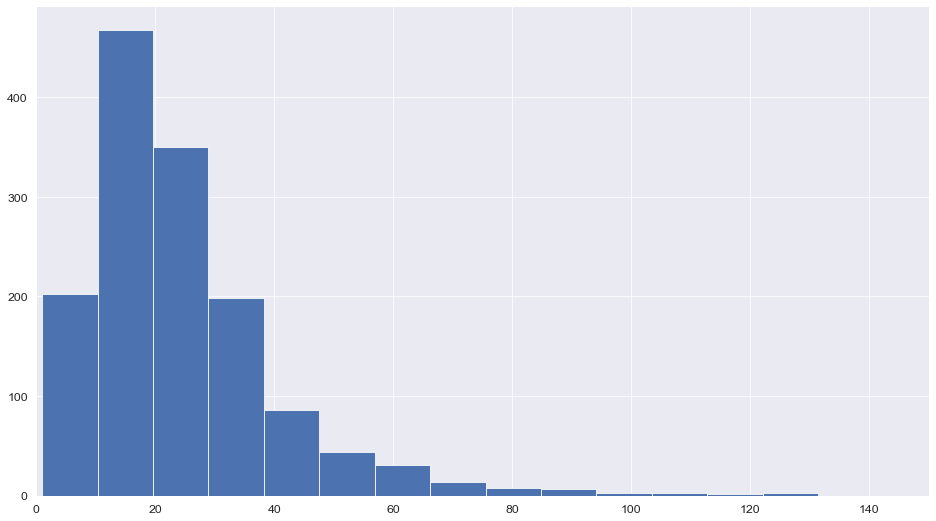

In [61]:
ax = total_user_data[total_user_data['passed_course']]['day'].hist(bins=35)
ax.set(xlim=(0, 150))

In [41]:
total_user_data[total_user_data['passed_course']]['day'].median()

20.0

In [42]:
min_user_date = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename(columns={'timestamp': 'min_timestamp'})
min_user_date.head()

user_id  min_timestamp
0        1     1472827464
1        2     1514383364
2        3     1434358476
3        5     1466156809
4        7     1521634660

In [43]:
total_user_data = total_user_data.merge(min_user_date \
                                        , on='user_id', how='outer') \
                                        .fillna(0)

In [44]:
total_user_data.head()

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  passed  \
0        1      1472827464          True      0.0    0.0           1       0   
1        2      1519226966          True      2.0    0.0           9       9   
2        3      1444581588          True     29.0   23.0          91      87   
3        5      1499859939          True      2.0    2.0          11      11   
4        7      1521634660          True      0.0    0.0           1       1   

   started_attempt  viewed  day  passed_course  min_timestamp  
0                0       1    1          False     1472827464  
1                2      10    2          False     1514383364  
2               30     192    7          False     1434358476  
3                4      12    2          False     1466156809  
4                0       1    1          False     1521634660

In [52]:
train_user_data = pd.DataFrame()

In [54]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [57]:
events_data.head()

step_id   timestamp      action  user_id                date         day  \
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15   
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15   
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15   
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15   
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15   

          user_time  
0  17632_1434340848  
1  17632_1434340848  
2  17632_1434340848  
3  17632_1434340895  
4  17632_1434340895

In [62]:
learning_time_border = 3 * 24 * 60 * 60

In [63]:
user_learning_time_border = min_user_date.user_id.map(str) + '_' \
                            + (min_user_date.min_timestamp + learning_time_border).map(str)

In [66]:
user_learning_time_border

0            1_1473086664
1            2_1514642564
2            3_1434617676
3            5_1466416009
4            7_1521893860
               ...       
19229    26790_1451743216
19230    26793_1510484231
19231    26794_1495546249
19232    26797_1508684516
19233    26798_1521234963
Length: 19234, dtype: object

In [67]:
min_user_date['user_learning_time_border'] = user_learning_time_border

In [69]:
events_data = events_data.merge(min_user_date, on='user_id', how='outer').fillna(0)

In [71]:
events_data = events_data.drop('min_timestamp', axis=1)

In [72]:
events_data

step_id   timestamp      action  user_id                date  \
0          32815  1434340848      viewed    17632 2015-06-15 04:00:48   
1          32815  1434340848      passed    17632 2015-06-15 04:00:48   
2          32815  1434340848  discovered    17632 2015-06-15 04:00:48   
3          32811  1434340895  discovered    17632 2015-06-15 04:01:35   
4          32811  1434340895      viewed    17632 2015-06-15 04:01:35   
...          ...         ...         ...      ...                 ...   
3480698    32814  1526762783  discovered      943 2018-05-19 20:46:23   
3480699    32814  1526762783      passed      943 2018-05-19 20:46:23   
3480700    32815  1526772750      viewed     5198 2018-05-19 23:32:30   
3480701    32815  1526772750  discovered     5198 2018-05-19 23:32:30   
3480702    32815  1526772750      passed     5198 2018-05-19 23:32:30   

                day         user_time user_learning_time_border  
0        2015-06-15  17632_1434340848          17632_1434600048  
1        2015-06-15  17632_1434340848          17632_1434600048  
2        2015-06-15  17632_1434340848          17632_1434600048  
3        2015-06-15  17632_1434340895          17632_1434600048  
4        2015-06-15  17632_1434340895          17632_1434600048  
...             ...               ...                       ...  
3480698  2018-05-19    943_1526762783            943_1527021864  
3480699  2018-05-19    943_1526762783            943_1527021864  
3480700  2018-05-19   5198_1526772750           5198_1527031950  
3480701  2018-05-19   5198_1526772750           5198_1527031950  
3480702  2018-05-19   5198_1526772750           5198_1527031950  

[3480703 rows x 8 columns]

In [74]:
events_data_train = events_data[events_data['user_time'] \
                                    <= events_data['user_learning_time_border']]

In [75]:
events_data_train.shape[0]

1014985

In [77]:
events_data_train = events_data_train.drop(['user_time', 'user_learning_time_border'] \
                                           , axis=1)

In [78]:
events_data_train.head()

step_id   timestamp      action  user_id                date         day
0    32815  1434340848      viewed    17632 2015-06-15 04:00:48  2015-06-15
1    32815  1434340848      passed    17632 2015-06-15 04:00:48  2015-06-15
2    32815  1434340848  discovered    17632 2015-06-15 04:00:48  2015-06-15
3    32811  1434340895  discovered    17632 2015-06-15 04:01:35  2015-06-15
4    32811  1434340895      viewed    17632 2015-06-15 04:01:35  2015-06-15

Check if valid

In [81]:
events_data_train.groupby('user_id') \
    .day.nunique().max()

4

Doing the same thing for submissions data

In [90]:
submissions_data['users_time'] = submissions_data.user_id.map(str) \ 
                                    + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(min_user_date[['user_id' \
                                                         , 'user_learning_time_border']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time \ 
                                              <= submissions_data.user_learning_time_border]

In [98]:
submissions_data_train = submissions_data_train.drop(['users_time' \
                                                      , 'user_learning_time_border'] \
                                                      , axis=1)

In [99]:
submissions_data_train.head()

step_id     timestamp submission_status  user_id                date  \
0  31971.0  1.434349e+09           correct    15853 2015-06-15 06:21:15   
1  31972.0  1.434348e+09           correct    15853 2015-06-15 06:05:00   
4  31976.0  1.434348e+09             wrong    15853 2015-06-15 06:02:03   
5  31976.0  1.434348e+09           correct    15853 2015-06-15 06:03:08   
7  31977.0  1.434347e+09           correct    15853 2015-06-15 05:49:31   

          day  
0  2015-06-15  
1  2015-06-15  
4  2015-06-15  
5  2015-06-15  
7  2015-06-15

In [107]:
submissions_data_train['user_id'].nunique()

8913

In [101]:
submissions_data_train.groupby('user_id') \
    .day.nunique().max()

4

In [143]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
                        .rename(columns={'day': 'days'})

steps_attempted = submissions_data_train.groupby('user_id') \
                        .step_id.nunique().to_frame().reset_index() \
                        .rename(columns={'step_id': 'steps_attempted'})

In [128]:
steps_attempted

user_id  steps_attempted
0           2                2
1           3                4
2           8               11
3          14                1
4          16               23
...       ...              ...
8908    26787                3
8909    26790                1
8910    26794               27
8911    26797                2
8912    26798                2

[8913 rows x 2 columns]

In [144]:
X = X.merge(steps_attempted, on='user_id', how='outer')
X = X.merge(pd.pivot_table(data=submissions_data_train, \
                              values='step_id', index='user_id', \
                              columns='submission_status', aggfunc='count', \
                              fill_value=0).reset_index(), on='user_id', how='outer')

In [145]:
X['correct_ratio'] = (X['correct'] / (X['correct'] + X['wrong'])).round(2)
X

user_id  days  steps_attempted  correct  wrong  correct_ratio
0           2     1                2        2      0           1.00
1           3     1                4        4      4           0.50
2           8     1               11        9     21           0.30
3          14     1                1        0      1           0.00
4          16     3               23       23     27           0.46
...       ...   ...              ...      ...    ...            ...
8908    26787     1                3        3      0           1.00
8909    26790     1                1        1      0           1.00
8910    26794     3               27       31      9           0.78
8911    26797     1                2        2      0           1.00
8912    26798     1                2        2      1           0.67

[8913 rows x 6 columns]

In [138]:
total_user_data

user_id  last_timestamp  is_gone_user  correct  wrong  discovered  \
0            1      1472827464          True      0.0    0.0           1   
1            2      1519226966          True      2.0    0.0           9   
2            3      1444581588          True     29.0   23.0          91   
3            5      1499859939          True      2.0    2.0          11   
4            7      1521634660          True      0.0    0.0           1   
...        ...             ...           ...      ...    ...         ...   
19229    26790      1517495987          True      1.0    0.0           8   
19230    26793      1510225034          True      0.0    0.0           1   
19231    26794      1512035039          True     33.0    9.0          69   
19232    26797      1509995096          True      2.0    0.0          10   
19233    26798      1520978742          True      2.0    1.0          12   

       passed  started_attempt  viewed  day  passed_course  min_timestamp  
0           0                0       1    1          False     1472827464  
1           9                2      10    2          False     1514383364  
2          87               30     192    7          False     1434358476  
3          11                4      12    2          False     1466156809  
4           1                0       1    1          False     1521634660  
...       ...              ...     ...  ...            ...            ...  
19229       8                1       9    4          False     1451484016  
19230       0                1       1    1          False     1510225031  
19231      69               34     180    9          False     1495287049  
19232      10                2      13    2          False     1508425316  
19233      12                3      12    1          False     1520975763  

[19234 rows x 12 columns]

In [146]:
X = X.merge(total_user_data[['user_id', 'is_gone_user', 'passed_course']] \
            , on='user_id', how='inner')

In [147]:
X.shape[0]

8913

In [148]:
X.isna().any().any()

False

In [149]:
X

user_id  days  steps_attempted  correct  wrong  correct_ratio  \
0           2     1                2        2      0           1.00   
1           3     1                4        4      4           0.50   
2           8     1               11        9     21           0.30   
3          14     1                1        0      1           0.00   
4          16     3               23       23     27           0.46   
...       ...   ...              ...      ...    ...            ...   
8908    26787     1                3        3      0           1.00   
8909    26790     1                1        1      0           1.00   
8910    26794     3               27       31      9           0.78   
8911    26797     1                2        2      0           1.00   
8912    26798     1                2        2      1           0.67   

      is_gone_user  passed_course  
0             True          False  
1             True          False  
2             True          False  
3             True          False  
4             True           True  
...            ...            ...  
8908          True          False  
8909          True          False  
8910          True          False  
8911          True          False  
8912          True          False  

[8913 rows x 8 columns]